In [41]:

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [42]:

import torch
import torch.nn as nn
import torch.optim as optim

In [43]:
data = pd.read_csv("encoded_data.csv")
# Separate features from outcome
X = data.drop(columns="status")
y = data["status"]

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


In [44]:
# Define two models
class Wide(nn.Module):
    """
    Single, wide hidden layer
    """
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(16, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class DeepSimple(nn.Module):
    """
    3 hidden, linear layers
    """
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(16, 16)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(16, 16)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(16, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class DeepComplex(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(16, 64)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [45]:
# Compare model sizes
model1 = Wide()
model2 = DeepSimple()
model3 = DeepComplex()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041
print(sum([x.reshape(-1).shape[0] for x in model3.parameters()]))  # 

1153
833
3713


In [46]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [47]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [48]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

cv_scores_deep_simple = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = DeepSimple()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep simple): %.2f" % acc)
    cv_scores_deep_simple.append(acc)

cv_scores_deep_complex = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = DeepComplex()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep complex): %.2f" % acc)
    cv_scores_deep_complex.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_simple_acc = np.mean(cv_scores_deep_simple)
deep_simple_std = np.std(cv_scores_deep_simple)
deep_complex_acc = np.mean(cv_scores_deep_complex)
deep_complex_std = np.std(cv_scores_deep_complex)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep Simple: %.2f%% (+/- %.2f%%)" % (deep_simple_acc*100, deep_simple_std*100))
print("Deep Complex: %.2f%% (+/- %.2f%%)" % (deep_complex_acc*100, deep_complex_std*100))

Accuracy (wide): 0.73
Accuracy (wide): 0.80
Accuracy (wide): 0.90
Accuracy (wide): 0.87
Accuracy (wide): 0.90
Accuracy (deep simple): 0.87
Accuracy (deep simple): 0.93
Accuracy (deep simple): 0.77
Accuracy (deep simple): 0.83
Accuracy (deep simple): 0.83
Accuracy (deep complex): 0.70
Accuracy (deep complex): 0.83
Accuracy (deep complex): 0.90
Accuracy (deep complex): 0.93
Accuracy (deep complex): 0.83
Wide: 84.00% (+/- 6.46%)
Deep Simple: 84.67% (+/- 5.42%)
Deep Complex: 84.00% (+/- 8.00%)


In [49]:
# rebuild model with full set of training data
if wide_acc > deep_simple_acc and wide_acc > deep_complex_acc:
    print("Retrain a wide model")
    model = Wide()
elif deep_simple_acc > wide_acc and deep_simple_acc > deep_complex_acc:
    print("Retrain a deep simple model")
    model = DeepSimple()
else:
    print("Retrain a deep complex model")
    model = DeepComplex()

acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()

Retrain a deep simple model
Final model accuracy: 90.77%


DeepSimple(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

[ 1.   51.    0.   54.    0.   61.    0.   60.    0.   60.64  0.    0.
  1.    0.    0.    1.  ] -> [0.27115077] (expected [0.])
[ 1.   74.    1.   62.    0.   68.    0.   74.    1.   57.99  0.    0.
  1.    1.    0.    0.  ] -> [0.9077269] (expected [1.])
[ 0.   67.    1.   70.    1.   65.    0.   88.    0.   71.96  0.    1.
  0.    0.    1.    0.  ] -> [0.23236312] (expected [0.])
[ 1. 70.  1. 63.  0. 70.  1. 55.  1. 62.  0.  0.  1.  0.  0.  1.] -> [0.92669857] (expected [1.])
[ 1.   80.    0.   70.    0.   72.    0.   87.    0.   71.04  0.    0.
  1.    0.    0.    1.  ] -> [0.6566947] (expected [1.])


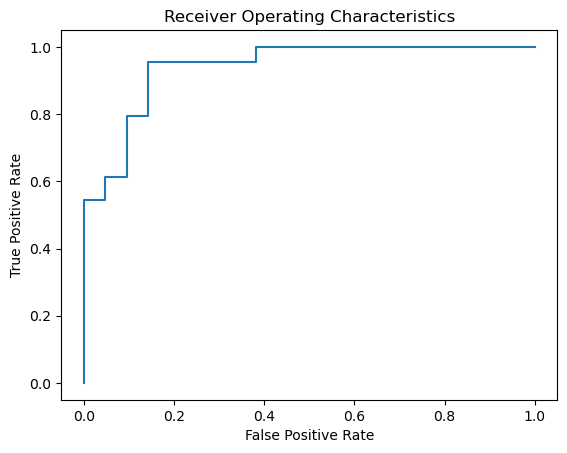

In [50]:
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()